In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../')
from copy import deepcopy
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import mne
from esinet.util import wrap_mne_inverse
from esinet import forward
from esinet.simulation import Simulation
from esinet.util import unpack_fwd
from esinet import util



# Forward Model

In [2]:
info = forward.get_info()
info['sfreq'] = 100
fwd_normal = forward.create_forward_model(info=info)
fwd_free = forward.create_forward_model(info=info, fixed_ori=False)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.4s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

In [25]:
settings = None # dict(duration_of_trial=5, number_of_sources=1, target_snr=10, extents=1)
sim_test = Simulation(fwd_normal, info, settings=settings).simulate(3)

Simulating data based on sparse patches.


100%|██████████| 3/3 [00:00<00:00, 2994.51it/s]

source data shape:  (1284, 100) (1284, 100)



100%|██████████| 3/3 [00:00<00:00, 108.40it/s]


In [26]:
method = 'lcmv'
n_baseline = 400
add_baseline = True

# pred = wrap_mne_inverse(fwd_free, sim_test, method=method, 
#         parallel=False, add_baseline=add_baseline, n_baseline=n_baseline,
#         weight_norm=None, reduce_rank=False, inversion='matrix',
#         rank='info', pick_ori=None, reg=0.05, regularize=False)

pred = wrap_mne_inverse(fwd_normal, sim_test, method=method, 
        parallel=False, add_baseline=add_baseline, n_baseline=n_baseline,
        weight_norm=None, reduce_rank=False, inversion='matrix',
        rank='info', pick_ori=None, reg=0.05, regularize=False)

  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:418: RuntimeWarning: Too few samples (required : 310 got : 100), covariance estimate may be unreliable
  data_cov = mne.compute_raw_covariance(raw, tmin=tmin,
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:418: RuntimeWarning: Too few samples (required : 310 got : 100), covariance estimate may be unreliable
  data_cov = mne.compute_raw_covariance(ra

(1284, 100) -5.1249837498430294e-09 6.64124432316766e-09


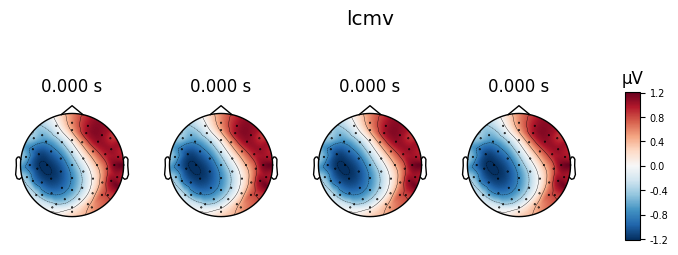

In [27]:
%matplotlib qt
from esinet import util
idx = 0
plot_params = dict(surface='white', hemi='both', verbose=0, backend='pyvista')
brain = sim_test.source_data[idx].mean().plot(**plot_params)
title = f'{sim_test.simulation_info.number_of_sources.values[idx]} sources'
brain.add_text(0.1, 0.9, title, 'title')
evoked_esi = util.get_eeg_from_source(sim_test.source_data[idx].mean().data, fwd_normal, info, tmin=0.)
evoked_esi.plot_topomap(title='True')

if len(pred[idx].data.shape) == 3:
    data = pred[idx].data
    pred[idx] = deepcopy(sim_test.source_data[idx])
    pred[idx].data = data.mean(axis=1)
print(pred[idx].data.shape, pred[idx].data.min(), pred[idx].data.max())
pred[idx] = pred[idx].mean()
pred[idx].data = np.real(pred[idx].data)

error = np.real(util.batch_nmse(sim_test.source_data[idx].mean().data, pred[idx].data))
r = np.real(util.batch_corr(sim_test.source_data[idx].mean().data, pred[idx].data))


brain = pred[idx].plot(**plot_params)
title = f'{method}, error: {error:.4}, r: {r}'
brain.add_text(0.1, 0.9, title, 'title')
evoked_esi = util.get_eeg_from_source(pred[idx].data, fwd_normal, info, tmin=0.)
evoked_esi.plot_topomap(title=method)




# Hyperparameter Optimization

In [138]:
weight_norms = ['nai', 'unit-noise-gain', 'unit-noise-gain-invariante', ]
reduce_ranks = [True, False]
inversions = ['single', 'matrix']
ranks = [None, 'full']
pick_oris = [None, 'normal', 'max-power', ]
regs = [0.001, 0.01, 0.05, 0.1]
regularizes = [True, False]
fwds = [fwd_free, fwd_normal]
fwds_names = ['fwd_free', 'fwd_normal']
method = 'lcmv'
n_baseline = 400
add_baseline = True
idx=0
results=[]
for weight_norm in weight_norms:
    for reduce_rank in reduce_ranks:
        for inversion in inversions:
            for rank in ranks:
                for pick_ori in pick_oris:
                    for reg in regs:
                        for regularize in regularizes:
                            for fwd, name in zip(fwds, fwds_names):
                                try:
                                    pred = wrap_mne_inverse(fwd, sim_test, method=method, 
                                        parallel=False, add_baseline=add_baseline, n_baseline=n_baseline,
                                        weight_norm=weight_norm, reduce_rank=reduce_rank, inversion=inversion,
                                        rank=rank, pick_ori=pick_ori,
                                        reg=reg, regularize=regularize)
                                    error = util.batch_nmse(sim_test.source_data[idx].data, pred[idx].data)
                                    r = util.batch_corr(sim_test.source_data[idx].data, pred[idx].data)
                                    result = dict(
                                            weight_norm=weight_norm,
                                            reduce_rank=reduce_rank,
                                            inversion=inversion,
                                            rank=rank,
                                            pick_ori=pick_ori,
                                            reg=reg,
                                            regularize=regularize,
                                            corr=r,
                                            nmse=error
                                        )
                                    results.append(result)
                                    print('\n', result, '\n')

                                except Exception as e:
                                    print("failed: ", e)
                                    continue
                            


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:388: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference(projection=True, verbose=verbose)#.apply_baseline(baseline=baseline)


failed:  reduce_rank cannot be used with inversion="single"; consider using inversion="matrix" if you have a rank-deficient forward model (i.e., from a sphere model with MEG channels), otherwise consider using reduce_rank=False


  0%|          | 0/3 [00:00<?, ?it/s]

Optimal settings:

weight_norm	reduce_rank	inversion	rank	pick_ori	reg	regularize	corr	nmse  
44	nai	True	matrix	full	max-power	0.050	False	0.182270+0.000000j	0.131376+0.000000j  
160	unit-noise-gain	True	matrix	full	max-power	0.001	False	0.148375+0.000000j	0.142099+0.000000j  
42	nai	True	matrix	full	max-power	0.010	False	0.130662+0.000000j	0.132040+0.000000j  
60	nai	False	single	None	None	0.100	True	0.086283+0.000000j	0.074528+0.000000j  
98	nai	False	matrix	None	None	0.100	True	0.085704+0.000000j	0.075305+0.000000j  

In [22]:
import pandas as pd
df = pd.DataFrame(results)

# df.sort_values('corr', ascending=False).head(5)
df.sort_values('nmse', ascending=True).head(5)

,weight_norm,reduce_rank,inversion,rank,pick_ori,reg,regularize,corr,nmse
115,nai,False,matrix,full,None,0.050,False,0.003351+0.000000j,0.018711+0.000000j
231,unit-noise-gain,False,matrix,full,None,0.001,False,0.004165+0.000000j,0.018793+0.000000j
234,unit-noise-gain,False,matrix,full,None,0.010,False,0.004892+0.000000j,0.018796+0.000000j
111,nai,False,matrix,full,None,0.001,False,0.012028+0.000000j,0.020422+0.000000j
72,nai,False,single,full,None,0.001,False,0.013305+0.000000j,0.020678+0.000000j
